# Normal Crossing RLCT Estimation

This notebook is measures the RLCT of normal crossings using two algorithms: SGNHT (Stochastic Gradient Nose-Hoover Thermostat) and SGLD (Stochastic Gradient Langevin Dynamics). The target model is a polynomial model characterized by $w_1^a * w_2^b$ for some $(a, b)$, where $w_1$ and $w_2$ are weights to be learned. The data generated around a given point $w_0$ with gaussian noise, so the model achieves its lowest loss when $w_1=0$ or $w_2 =0$. We estimate the RLCTs at the origin, and at points where either $w_1=0$ or $w_2=0$, but not both.

In [1]:
import math
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim.sgd import SGD
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

if "google.colab" in sys.modules:
    %pip install git+https://github.com/timaeus-research/devinterp.git@add/colab

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT
from devinterp.slt.sampler import estimate_rlct, sample
from torch.utils.data import TensorDataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def train_one_batch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        break
    return train_loss


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    model.train()
    return test_loss / len(test_loader)

In [3]:
class PolyModel(nn.Module):
    def __init__(self, powers):
        super(PolyModel, self).__init__()
        self.weights = nn.Parameter(
            torch.tensor([1.0, 0.3], dtype=torch.float32, requires_grad=True)
        )
        self.powers = powers

    def forward(self, x):
        multiplied = torch.prod(self.weights**self.powers)
        x = x * multiplied
        return x


powers = torch.tensor([1, 2])  # w1 * w2^2
model = PolyModel(powers)
sigma = 0.25
lr = 0.0005
num_train_samples = 5000
num_test_samples = 1000
batch_size = num_train_samples
w_true = torch.zeros_like(powers)

x = torch.normal(0, 2, size=(num_train_samples,))
y = sigma * torch.normal(0, 1, size=(num_train_samples,))
train_data = TensorDataset(x, y)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
rlct_estimates = []
criterion = F.mse_loss
test_loss = 0.0


def print_rlcts(n_estimates=50):
    rlct_estimates_sgnht = []
    rlct_estimates_sgdl = []
    for _ in range(n_estimates):
        rlct_estimate_sgnht = estimate_rlct(
            model,
            train_loader,
            criterion=criterion,
            optimizer_kwargs=dict(
                lr=lr,
                diffusion_factor=0.01,
                bounding_box_size=1.0,
                num_samples=len(train_data),
                batch_size=batch_size,
            ),
            sampling_method=SGNHT,
            num_chains=1,
            num_draws=1_000,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            verbose=False,
        )
        rlct_estimate_sgdl = estimate_rlct(
            model,
            train_loader,
            criterion=criterion,
            optimizer_kwargs=dict(
                lr=lr,
                bounding_box_size=1.0,
                elasticity=1.0,
                temperature="adaptive",
                num_samples=len(train_data),
            ),
            sampling_method=SGLD,
            num_chains=1,
            num_draws=1_000,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            verbose=False,
        )

        if not math.isnan(rlct_estimate_sgnht):
            rlct_estimates_sgnht += [rlct_estimate_sgnht]
        if not math.isnan(rlct_estimate_sgdl):
            rlct_estimates_sgdl += [rlct_estimate_sgdl]
    plt.hist(rlct_estimates_sgnht, alpha=0.5, label="sgnht")
    plt.hist(rlct_estimates_sgdl, alpha=0.5, label="sgdl")
    plt.legend()
    plt.show()

    print(
        f"estimated rlct: sgnht: {np.mean(rlct_estimates_sgnht)}, sgdl: {np.mean(rlct_estimates_sgdl)}"
    )

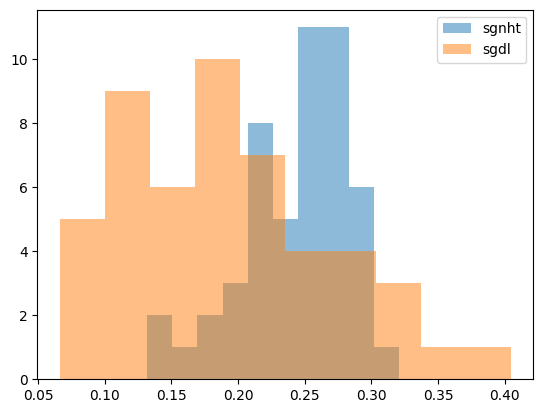

estimated rlct: sgnht: 0.24344669413051268, sgdl: 0.19281000760739628


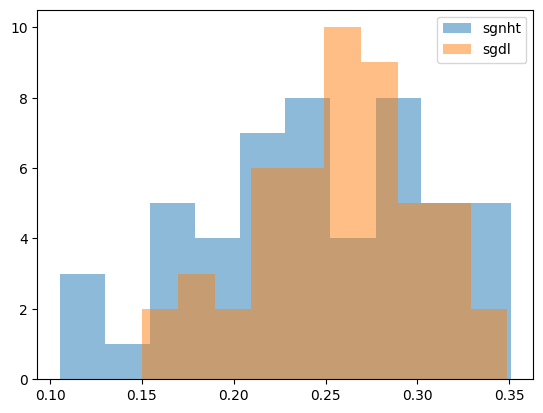

estimated rlct: sgnht: 0.2424394503124231, sgdl: 0.2575646550292813


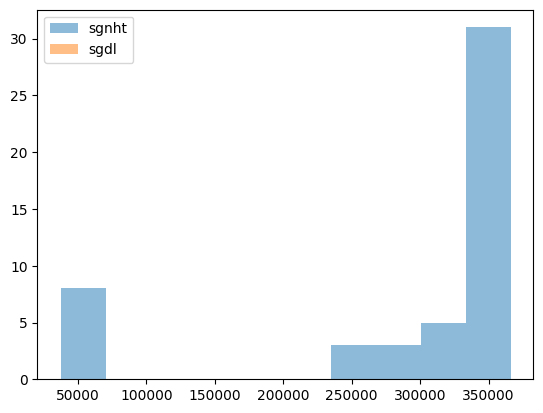

estimated rlct: sgnht: 295226.49783525977, sgdl: 36929.20804473391


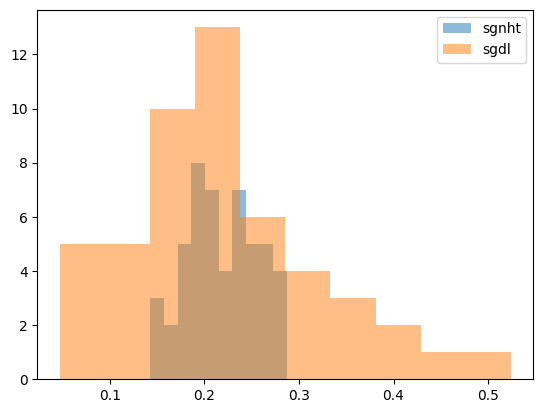

estimated rlct: sgnht: 0.2193964434863927, sgdl: 0.21884466278422163


In [4]:
model.weights = nn.Parameter(
    torch.tensor([0.0, 0.0], dtype=torch.float32, requires_grad=True)
)
print_rlcts()

model.weights = nn.Parameter(
    torch.tensor([2.0, 0.0], dtype=torch.float32, requires_grad=True)
)
print_rlcts()

model.weights = nn.Parameter(
    torch.tensor([0.0, 3.0], dtype=torch.float32, requires_grad=True)
)
print_rlcts()

model.weights = nn.Parameter(
    torch.tensor([0.01, 0.01], dtype=torch.float32, requires_grad=True)
)
print_rlcts()

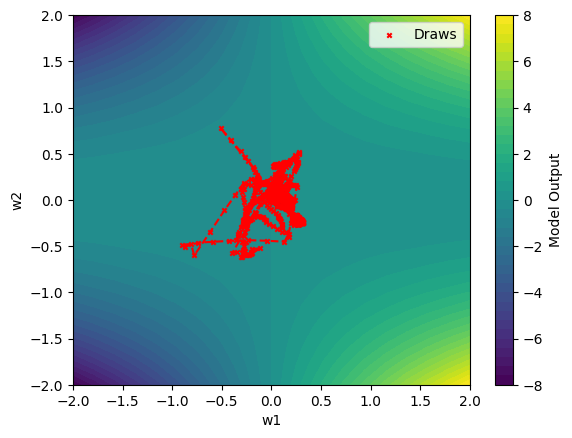

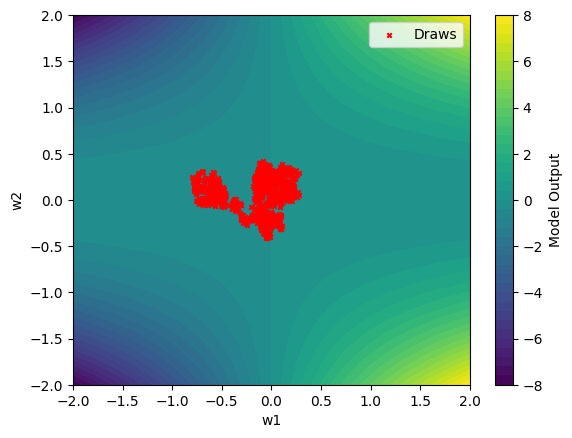

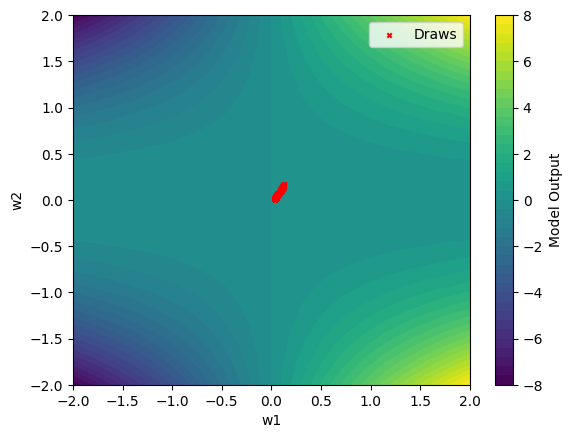

In [17]:
def plot_trajectory(trace):
    weights = trace["model_weights"]
    w1_range = np.linspace(-2, 2, 20)
    w2_range = np.linspace(-2, 2, 20)
    w1_vals, w2_vals = np.meshgrid(w1_range, w2_range)
    Z = np.zeros_like(w1_vals, dtype=float)

    for i in range(w1_vals.shape[0]):
        for j in range(w1_vals.shape[1]):
            w1 = w1_vals[i, j]
            w2 = w2_vals[i, j]
            model.weights = nn.Parameter(torch.tensor([w1, w2], dtype=torch.float32))
            Z[i, j] = model(torch.tensor(1.0)).item()

    plt.contourf(w1_vals, w2_vals, Z, levels=50, cmap="viridis")
    plt.colorbar(label="Model Output")

    # Plot the draws with lines
    draws_array = np.array(
        [
            d
            for d in weights
            if w1_range[0] <= d[0] <= w1_range[-1]
            and w2_range[0] <= d[1] <= w2_range[-1]
        ]
    )
    plt.scatter(
        draws_array[:, 0], draws_array[:, 1], c="r", marker="x", s=10, label="Draws"
    )
    plt.plot(draws_array[:, 0], draws_array[:, 1], "r--")

    plt.xlabel("w1")
    plt.ylabel("w2")
    plt.legend()
    plt.show()


train_loader = DataLoader(train_data, batch_size=1, shuffle=True)

model.weights = nn.Parameter(
    torch.tensor([0.1, 0.1], dtype=torch.float32, requires_grad=True)
)

trace_sgnht = sample(
    model,
    train_loader,
    criterion=criterion,
    optimizer_kwargs=dict(
        lr=lr,
        diffusion_factor=0.01,
        bounding_box_size=1.0,
        num_samples=len(train_data),
        batch_size=batch_size,
    ),
    sampling_method=SGNHT,
    num_chains=1,
    num_draws=1_000,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    verbose=False,
    return_weights=True,
)
trace_sgdl = sample(
    model,
    train_loader,
    criterion=criterion,
    optimizer_kwargs=dict(
        lr=lr,
        bounding_box_size=1.0,
        elasticity=1.0,
        temperature="adaptive",
        num_samples=len(train_data),
    ),
    sampling_method=SGLD,
    num_chains=1,
    num_draws=1_000,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    verbose=False,
    return_weights=True,
)
trace_sgd = sample(
    model,
    train_loader,
    criterion=criterion,
    optimizer_kwargs=dict(lr=1000 * lr),
    sampling_method=SGD,
    num_chains=1,
    num_draws=1_000,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    verbose=False,
    return_weights=True,
)
plot_trajectory(trace_sgnht)
plot_trajectory(trace_sgdl)
plot_trajectory(trace_sgd)